# Introduction
ABCGAN (atmospheric background characterization 'GAN') is a generative adversarial network that reproduces realistic physical profiles of the upper atmosphere and ionosphere.  Unlike traditional empirical models, ABCGAN can produce not only the average profile under particular conditions, but also the expected distribution of parameters.  This allows the GAN to estimate the probability that a given profile is part of the historical distribution, enabling it to determine if an event is hightly unusualy (outside the range of "normal" atmospheric variation).

The model was trained on historical measurements collected from the Poker Flat Incoherent Scattering Radar (PFISR) from 2007-2020.  PFISR measures profiles of the scalar plasma parameters electron density (Ne), electron temperature (Te), and ion temperature (Ti) in the ionosphere.  For more information about the training data, visit amisr.com.

ABCGAN is valid for predicting average ionospheric parameters over Poker Flat, AK.  The results should also be reasonable for most locations in the auroral zone, but caution should be excercied using the GAN results in other latitude regiems.

# Summary

This file provides a demonstration of the abcgan project. This includes using the Generator to generate data consistent
with the historically observed distribution and using the discriminator to detect whether measurements are consistent
with the historically observed distribution.

## Imports

Several imports are used. In particular we load `numpy`, which provides the formats for data input output.
We also use the numpy library for calculation of statistics and simulating fake data. We load `abcgan` which
has both the generator and the discriminator that we will use. Finally, we load `matplotlib.pyplot`, `seaborn`,
and `pandas` for display.

In [1]:
import numpy as np  # numerics
import abcgan  # abcgan package
import matplotlib.pyplot as plt  # plotting
import seaborn as sns  # plotting
import pandas as pd  # plotting
import h5py  # reading hdf5 files
import matplotlib.image as mpimg
import abcgan.constants as const
import abcgan.transforms as trans
from abcgan.interface import estimate_drivers
from abcgan.mask import prev_driver_mask
import time

## Loading Drivers and Background Variables

** Replace with or link to drivers notebook? **

We need to first get the driving parameters. We first load a set of relevant drivers that are stored in hdf5 format.
 We print the keys to show the saved list of drivers. We then convert to a standard python dictionary from hdf5 format
  then use `abcgan.stack_drivers` to aggregate the drivers for input to the generator. For this demo we will only be
  using 500 samples to simplify things. We also gather the unix time stamp for each driver sample, which will
   be used later for estimating future driver samples.Some of the samples might be missing a driver feature, which we can mask
  out by looking for any nans in a sample.

In [2]:
fname = 'tutorial_continuous.h5'
start_sample, end_sample = 2000, 2500
with h5py.File(fname, 'r') as hf:
    driver_dict = hf['Drivers']
    print(list(driver_dict.keys()))
    driver_dict = {k: v[()] for k, v in driver_dict.items()}
    unix_time = hf['UnixTime'][()]
    drivers = abcgan.stack_drivers(driver_dict)

    valid_samples = ~np.isnan(drivers).any(-1)
    unix_time = unix_time[valid_samples][start_sample:end_sample]
    drivers = drivers[valid_samples][start_sample:end_sample, :]

['Ap', 'F10.7', 'F10.7avg', 'MEI', 'MLT', 'RMM1', 'RMM2', 'SLT', 'SZA', 'TCI', 'ap', 'moon_phase', 'moon_x', 'moon_y', 'moon_z']


The list of drivers keys printed above corresponds to the following physical parameters:

| Key        | Full Name                      | Description                                                                  |
| ---------- | ------------------------------ |----------------------------------------------------------------------------- |
| SLT        | Solar Local Time               | Local time as determined by the sun's position                               |
| MLT        | Magnetic Local Time            | Local time calculated used magnetic coordinate system                        |
| SZA        | Solar Zenith Angle             | Angle between the sun and local zenith                                       |
| ShadHeight | Shadow Height                  | Height of the Earth's shadow in the atmosphere                               |
| moon_x     | Lunar Position - x             | X component of Lunar position in ECEF coordinates                            |
| moon_y     | Lunar Position - y             | Y component of Lunar position in ECEF coordinates                            |
| moon_z     | Lunar Position - z             | Z component of Lunar position in ECEF coordinates                            |
| moon_phase | Lunar Phase                    | Lunar phase in degrees                                                       |
| ap         | ap Geomagnetic Index           | Three hour equivilent planetary amplitude                                    |
| Ap         | Daily Ap Index                 | Daily equivalent planetary aplitude                                          |
| F10.7      | F10.7 Solar Radio Flux         | Solar rado flux at 10.7 cm (2800 MHz) in s.f.u (10^-22 W m^-2 Hz^-1)         |
| F10.7a     | Average F10.7 Solar Radio Flux | Average solar rado flux at 10.7 cm (2800 MHz) in s.f.u (10^-22 W m^-2 Hz^-1) |
| TCI        | Thermosphere Climate Index     | 60-day running average of global cooling power radiated from the thermosphere |
| MEI        | Multivariate ESNO Index        | Measure of the El Nino/Southern Oscillation (ESNO)/sea surface temperature   |
| RMM1       | First MJO Index                | First component of the Madden-Julian Osscillation Indices                    |
| RMM2       | Second MJO Index               | Second component of the Madden-Julian Osscillation Indices                   |



Each driver is stored as a separate vector in `tutorial_v7.h5`, where each entry in the vector is a separate sample.
So the full set of drivers for the first sample consists of the first element in each vector. The stacking routine
`abcgan.stack_drivers` collates these into a single data structure which has size nSamples x nDrivers, in the order
specified by `abcgan.driver_names`. `abcgan.stack_drivers` can accept either an `h5py.Group` object directly or
as shown above a dictionary mapping each driver name to a one dimensional numpy array.

See the tutorial on generating and saving drivers in this directory for how to create a driver file.

## Load Background Variables

We can load a sample of background variable observations collected at the same time as each of the sampled drivers and will be
 used later to compare our generated background values with the actual background values in the h5 file. The file contains about 5000 samples,
  but for this demo we will only be using the first 500 samples to simplify things. Note that here we directly stack the background
   variables using `abcgan.stack_bvs` from the `h5py.Group`. In the hdf5 file each background variable is saved as a single
   array of size nSamples x nAltitude, where missing values are padded with nans. Note that the first dimensions (number of samples)
    is 500, corresponding to the 500 sets of drivers. The final dimension is 6 corresponding to the number of background variables.
    In case there was any invalid driver samples we apply the same valid mask to the background variables

In [3]:
with h5py.File(fname, 'r') as hf:
    bvs = abcgan.stack_bvs(hf['BackgroundValues'])
    bvs = bvs[valid_samples][start_sample:end_sample, :, :]
    print(bvs.shape)

(500, 30, 12)


The background parameters, in the order specified by `abcgan.bv_names`, are:

| Parameter | Variable Name | Units |
|-----------|---------------|-------|
| Average Electron Density | Ne_bac | m$^{-3}$ |
| Root Mean Square Variation of Electron Density | Ne_rms | m$^{-3}$ |
| Average Electron Temperature | Te_bac | K |
| Root Mean Square Variation of Electron Temperature | Te_rms | K |
| Average Ion Temperature | Ti_bac | K |
| Root Mean Square Variation of Ion Temperature | Ti_rms | K |
| Average Ion Velocity East | Ve_bac | m/s |
| Root Mean Square Variation of Ion Velocity East | Ve_rms | m/s |
| Average Ion Velocity North | Vn_bac | m/s |
| Root Mean Square Variation of Ion Velocity North | Vn_rms | m/s |
| Average Ion Velocity Up | Vu_bac | m/s |
| Root Mean Square Variation of Ion Velocity Up | Vu_rms | m/s |
| Average Neutral Density | Nn_bac | m$^{-3}$ |
| Average Neutral Temperature | Tn_bac | K |


Averages and root mean square values are over the standard smoothing window of 1 hour.

## Altitudes
The ABC GAN predicts background values on a set, non-uniform altitude grid.  The non-uniform grid was chosen to be higher resolution in the lower atmosphere where important dynamics occur at smaller scales, but lower resolution at high altitudes where the atmosphere is more stable across a larger range and data is sparser.

| Altitude Range | Grid Spacing |
|----------------|--------------|
| 90 - 120 km    | 4.5 km       |
| 120 - 150 km   | 9 km         |
| 150 - 200 km   | 18 km        |
| 200 - 800 km   | 24 km        |


In [4]:
altgrid = np.concatenate((np.arange(92.,119.,4.5),np.arange(119.,146.,9.),np.arange(146.,200.,18.),np.arange(200.,800.,24.)))    # altitude grid
altgrid = altgrid[:30]

## Generate

Given the driving parameters we can now generate a set of measurements, one for each sample.

The output is an array of measurements, one for each altitude bin, for each driver. In this case there are different sets of driving parameters. We choose to generate 30 altitude bins worth of data (which is both the default and the maximum as specified in `abcgan.max_alt`). There are six background variables generated for each sample for each altitude bin.

In [5]:
meas = abcgan.generate(drivers, n_alt=30)
print(meas.shape)
print(abcgan.bv_names)

(500, 30, 12)
['Ne_bac', 'Ne_rms', 'Te_bac', 'Te_rms', 'Ti_bac', 'Ti_rms', 'Ve_bac', 'Ve_rms', 'Vn_bac', 'Vn_rms', 'Vu_bac', 'Vu_rms']



## Sampling

To generate multiple samples for the same driving parameters (usually in order to compute statistics) pass a repeated version of the drivers. Each output will be a separate sample. Here we generate 50 samples using the first set of saved drivers.

In [6]:
meas_sampled = abcgan.generate(drivers[:1, :].repeat(50, 0))
print(meas_sampled.shape)


(50, 30, 12)


## Compare Generated Profile
As a practical example, look at several real profiles of electron density from the background values data with similar driving conditions and compare them to the set of profiles generated by the GAN for these drivers.  First identify points from the sample data set that were close to noon MLT with Ap<5 and F10.7<80.  Then find the average driving conditions for these points and use them to generate sampled profiles with the GAN.

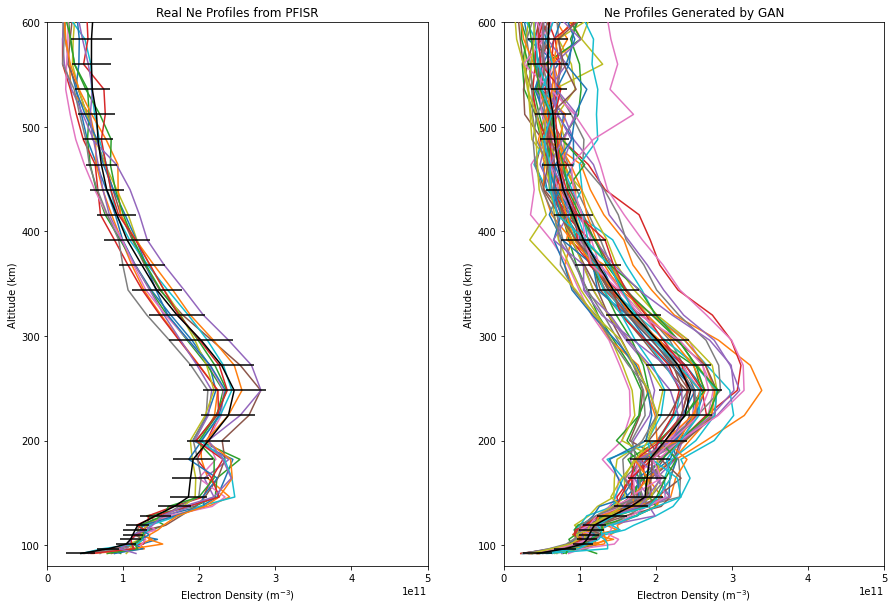

In [7]:
idx = np.argwhere((np.abs(drivers[:,3]-12.)<1.) & (drivers[:,0]<5.) & (drivers[:,1]<80.)).flatten()
avg_drivers = np.mean(drivers[idx,:], axis=0)[None,:]

gen_profiles = abcgan.generate(avg_drivers.repeat(50, 0))
mean_profile = np.mean(gen_profiles, axis=0)
std_profile = np.std(gen_profiles, axis=0)

fig, ax = plt.subplots(1, 2, figsize=(15, 10))

ax[0].plot(bvs[idx,:,0].T, altgrid, zorder=3)
ax[0].set_title('Real Ne Profiles from PFISR')

ax[1].plot(gen_profiles[:,:,0].T, altgrid[:30], zorder=3)
ax[1].set_title('Ne Profiles Generated by GAN')

for i in range(2):
    ax[i].errorbar(mean_profile[:,0], altgrid[:30], xerr=std_profile[:,0], color='black', zorder=5)
    ax[i].set_xlim([0.,5.e11])
    ax[i].set_ylim([80.,600.])
    ax[i].set_xlabel(r'Electron Density (m$^{-3}$)')
    ax[i].set_ylabel('Altitude (km)')
    
plt.show()

The black profile in both plots is the mean and standard deviation of the sampled profiles from the GAN.  They agree with the measured profiles, and contain information about the expected spread of the electron density at each altitude.

The output of the GAN is **statistical**, and each individual generated profile is a sampled profile from the distribution but does not necessarily represent the "average" or "typical" conditions.

## Scoring 

To score the background variables we run the critic providing both the drivers and the measurements. Each altitude
is scored separately, corresponding to how well the measurements at that altitude fit the historically observed
distribution, conditional upon both the drivers and all lower altitude measurements. To score the entire measurement
set overall we sum the contributions from all altitude bins.

In [9]:
real_score = abcgan.discriminate(drivers, bvs)
print(real_score.shape)
total_score = real_score.sum(-1)
print(total_score.shape)

(500, 30)
(500,)


To score only the first ten bins we can just provide the first 10 data points.

In [10]:
bin_score = abcgan.discriminate(drivers, bvs[:, :10, :])
print(bin_score.shape)
total_score = bin_score.sum(-1)
print(total_score.shape)

(500, 10)
(500,)


We can directly compare the average scores of the real data versus obviously fake data.

In [11]:
mean_real = real_score.mean()
mean_fake = abcgan.discriminate(drivers, np.ones(bvs.shape)).mean()
print(f'Real: {mean_real}')
print(f'Fake: {mean_fake}')

Real: 1.576124668121338
Fake: 12.636296272277832


## Exploring the results

The above utilities are still being tested and developed. We expect to soon have the following included in the tutorial:
- Demonstration showing how to compare the histograms of generated data with historically observed data.
- Demonstrate how to use the discriminator score to distinguish real and fake data, including improved calibration.

Select an altitude bin, say the 25th, to compare histograms and filter out any possible outliers in the data using `valid_mask` created from `transforms.scale(bvs)` function.

In [11]:
alt_bin = 20
_, valid_mask = abcgan.transforms.scale_bv(bvs)
real = bvs[valid_mask, alt_bin, :]
generated = meas[valid_mask, alt_bin, :]

We can then compare the distributions of the `real` and `generate` values for each of the
6 background variables using a kde plot implemented with matplotlib and seaborn. The nested for loop iterates over each of the 6 distubtions plots we want make. One is added to the `real` and `generated` values to avoid log scaling values less than or equal to zero

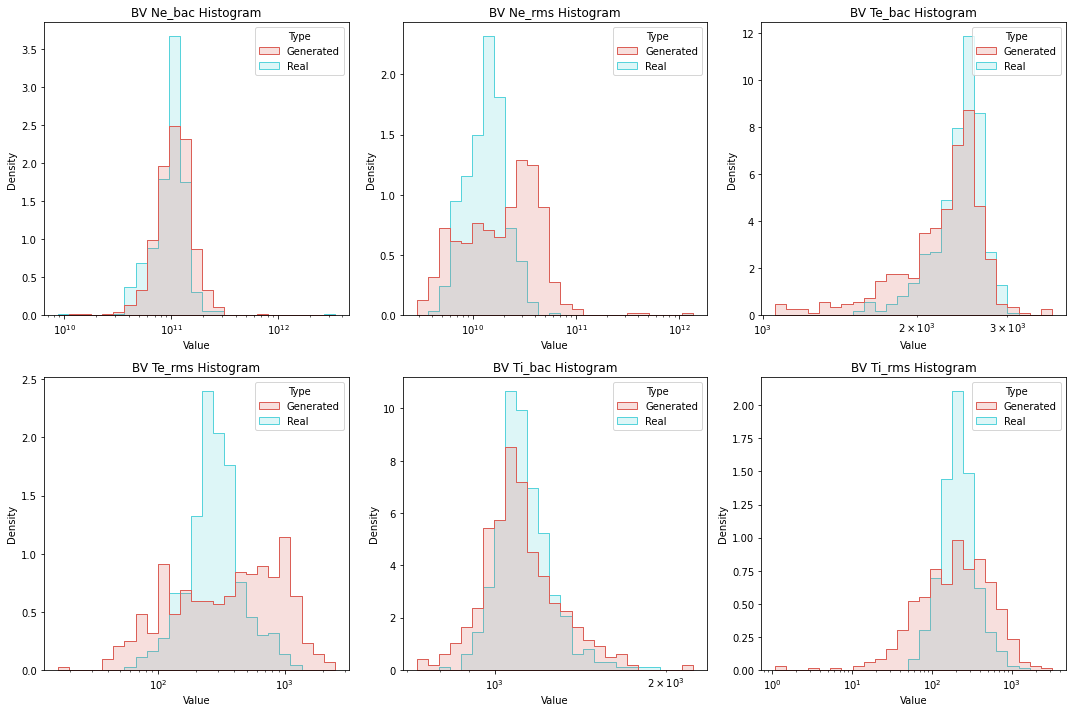

In [12]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i in range(2):
    for j in range(3):
        var1 = 1 + real[..., 3*i + j].flatten()
        var2 = 1 + generated[..., 3*i + j].flatten()
        x = np.hstack((var1, var2))
        hue = ['Real'] * len(var1) + ['Generated'] * len(var2)
        data = pd.DataFrame({'Value': x, 'Type': hue})
        sns.histplot(data=data, x='Value', hue='Type', ax=ax[i, j],
                     element='step', bins=25, legend=True, stat='density',
                     palette='hls', alpha=0.2, common_norm=False,
                     hue_order=['Generated', 'Real'], log_scale=True)
        ax[i, j].set_title(f'BV {abcgan.constants.bv_names[3*i + j]} Histogram')
plt.tight_layout()
plt.show()


## Using Previous Drivers To Estimate Current Drivers

In the situation that you don't have the current drivers available for predicting the background profile you can use the
driver estimation model to predict the current driver features based on previous driver samples. Specifically the driver estimation
model has been trained to predict a driver sample that occur 2 hours from the time of the input sample. We can simulate the situation
in which we only have drivers sample from two hours ago by creating a new driver dataset containing of driver samples that occurred two
hours from the actual background variable samples. Since the time difference between each sample isn't always the same in our dataset we
have to calculate a mapping vector between current samples and previous samples from two hour ago. The `prev_driver_mask` function
generates this mapping vector along with a mask for selecting the driver samples that have a previous driver sample from two hours ago, which we
will use when evaluating the driver estimator.

In [18]:
prev_dr_map, dr_mask = prev_driver_mask(unix_time)
prev_drivers = drivers[prev_dr_map]

We can now estimate the current driver samples from the previous by calling the `estimate_drivers` function. As you can see the
estimated drivers are very similar to actual driver samples. Note that when using in realtime you can simply call the
estimate driver function with two hour old driver samples to predict the current driver samples.

In [19]:
est_drivers = estimate_drivers(prev_drivers, model='dr_gan')
print(f'Original Driver Shape: {drivers.shape}')
print(f'Estimated Driver Shape: {est_drivers.shape}')

Original Driver Shape: (500, 15)
Estimated Driver Shape: (449, 15)


We can look at how the estimated driver distribution compares to the actual driver samples. As you can see the
estimated drivers are very similar to actual driver samples. From here you can pass the estimated driver samples
into the background variable generator to estimate the current background profile.

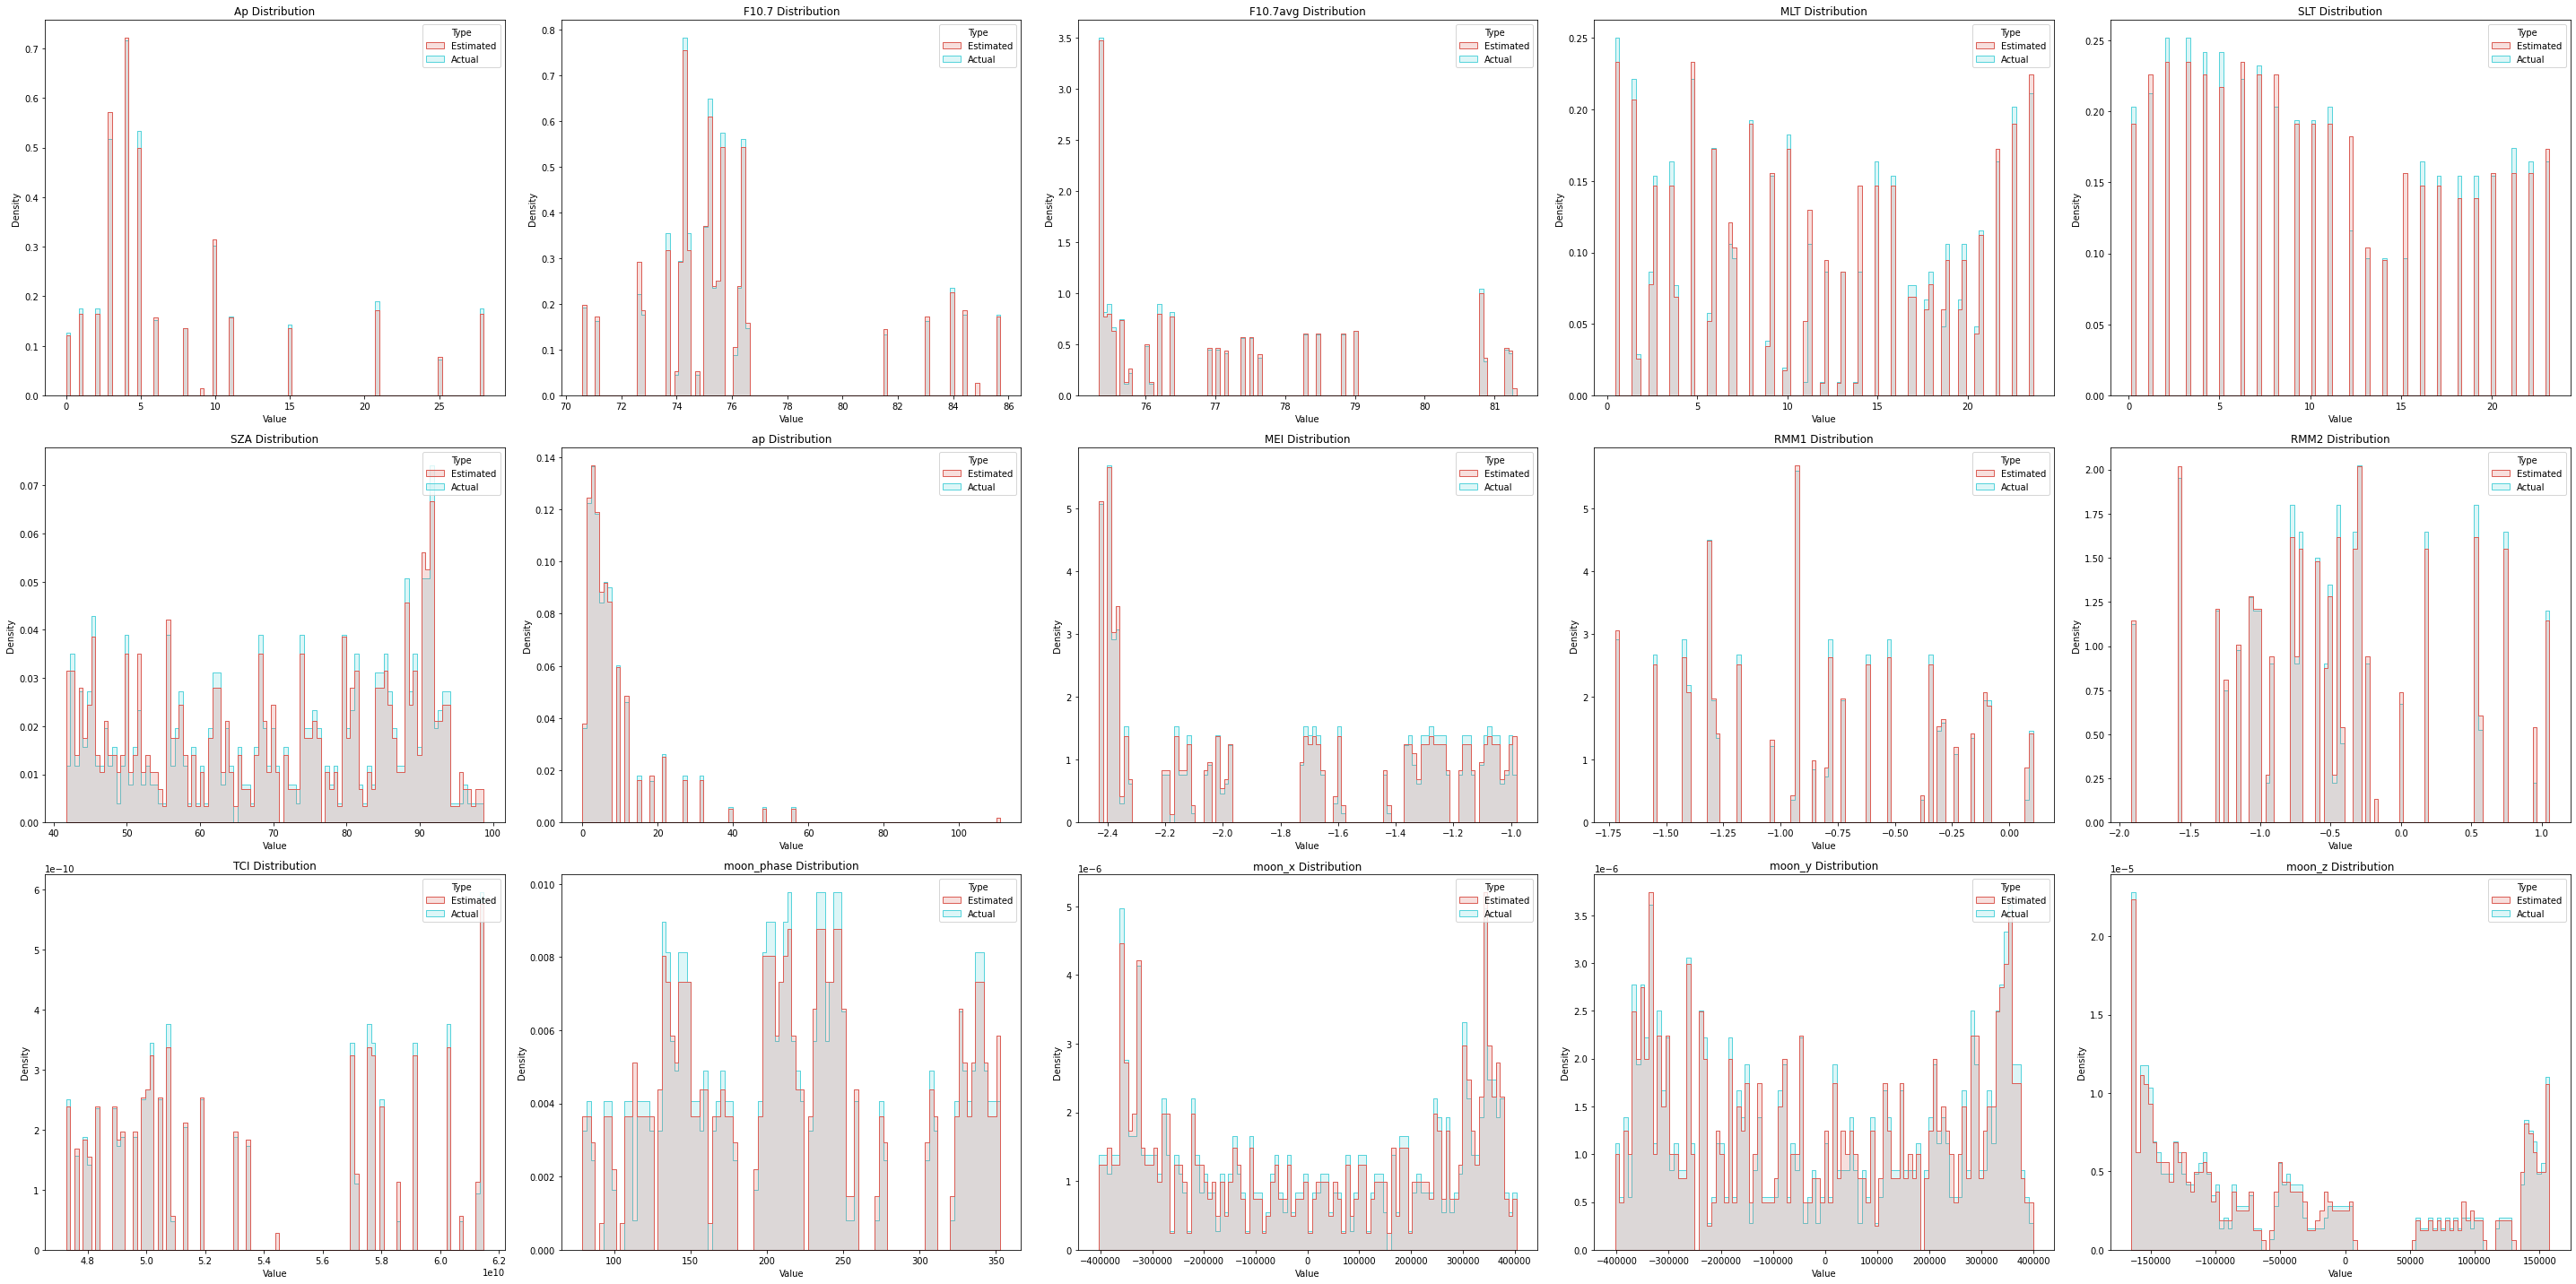

In [17]:
i_range = 3
j_range = 5
fig, ax = plt.subplots(i_range, j_range, figsize=(40, 20))
for i in range(i_range):
    for j in range(j_range):
        x1 = drivers[:, j_range * i + j]
        x2 = prev_drivers[:, j_range * i + j]
        x = np.hstack((x1, x2))
        hue = ['Estimated'] * len(x1) + ['Actual'] * len(x2)
        data = pd.DataFrame({'Value': x, 'Type': hue})
        sns.histplot(data=data, x='Value', hue='Type', ax=ax[i, j],
                     element='step', bins=100, legend=True, stat='density',
                     palette='hls', alpha=0.2,
                     hue_order=['Estimated', 'Actual'],
                     common_norm=False)
        ax[i, j].set_title(f'{const.driver_names[j_range * i + j]} Distribution')
plt.tight_layout()
plt.show()

## Detecting Anomalies with the GAN

GANs offer a convenient way to realize an anomaly detector. First, we apply the GAN to regenerate the statistical distribution of our dataset. Then, new data is compared to the
generated statistical distribution using a 'log-probability' distance measure.

## Background
To compute the anomaly score, we apply a distance measure between new samples and a distribution of values generated by the GAN. To motivate our approach, first consider
scalar data. For simplicity, assume our model is a random variable, so repeated calls to the GAN will generate a normal distribution centered around a mean value $\mu$
with standard deviation $\sigma$, then we may estimate the probability $p$ of a new signal $x$ comes from the distribution as

$$p(x) = \frac{exp(-\frac{1}{2}{\delta}^2)}{\sigma \sqrt{2 \pi}}.$$

We define a dimensionless variable $\delta = (x-\mu)/\sigma $. As the distance to the new point $\delta$ increases, the exponential may underflow, or be too small to evaluate exactly. To fix underflow, we compute the
log of the exponent to estimate an anomaly score, $A$.

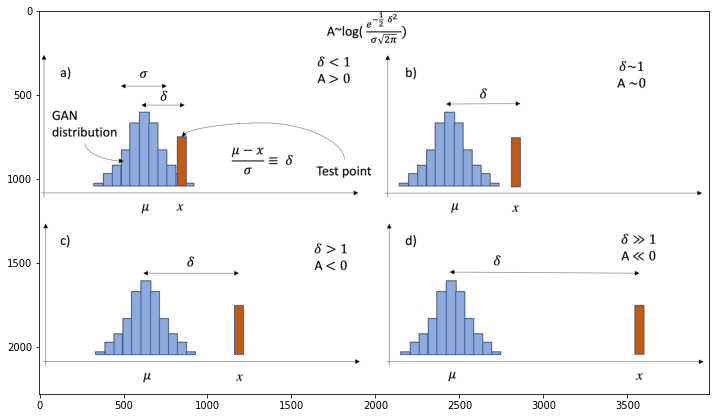

In [15]:
img = mpimg.imread('img/anom-normal.png')
plt.figure(figsize = (12,12))
plt.imshow(img)

In plots $a)$ and $b)$, the distance to the distribution is small, so the exponential evaluates to value close to unity. However,
as the new sample distance increases as in plots $ c)$ and $ d)$, the exponential evaluates to a very small number and is likely to underflow, meaning the value will be essentially zero.

## Putting it all together

For our distance measure, we compute sum the exponential distances between the new sample point and 10,000 GAN-generated samples. The net effect is that we treat each new measurement as a random variable and the anomaly
score tracks whether our new measurement is similar to any of the generated data points. If any of the GAN points overlaps with the new data, then it drives the anomaly score to a positive number. However, if none of the generated points lies near the sample data, then the anomaly score returns a negative number.
To capture distances within the joint distribution, we compute the L2 norm between the N-dimensional sample and each generated data point, assuming a standard deviation $\sigma_N$ computed from the geometric mean of all $N$ features $\sigma_N = 2* \sqrt[N]{(\prod \sigma_i)}/M$. Note the standard deviation was divided by the number of generated samples $M$ = 10,000.
Finally, we compute the anomaly score $A$ for a given sample $x$ with numpy's built-in $logsumexp$ function, which is simply a numerically stable form of

$$A(x) = log(\sum_{i}e^{-1/2 {||\hat{x}-\hat{\mu}||}^2/\sigma_N^2}).$$


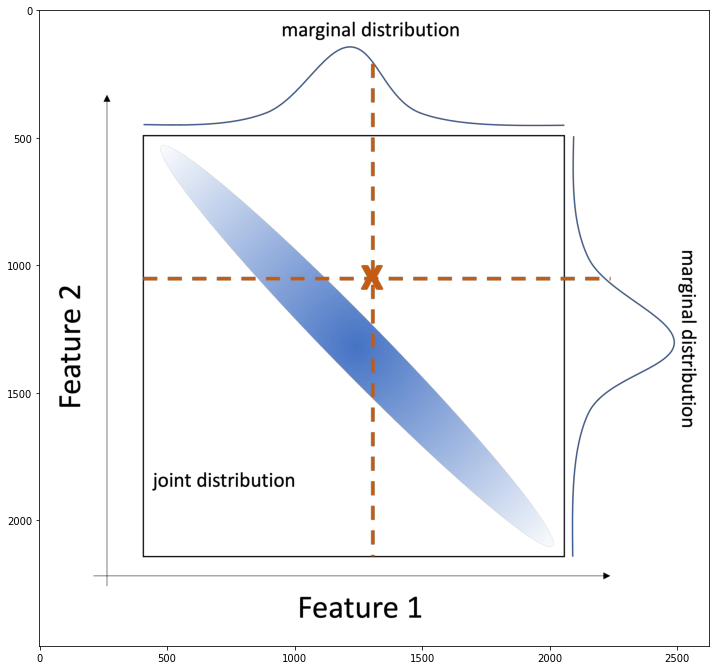

In [16]:
img = mpimg.imread('img/marginal_vs_joint.png')
plt.figure(figsize = (12,12))
plt.imshow(img)

## Anomaly Example

Fist we have to Generate fake data.
Recall fakes at upper altitudes are conditioned on real data.
Here we select a particular record with anomalies in the upper altitudes.

In [17]:
bv_type = 'radar '
if bv_type == 'lidar':
    n_alt = const.max_alt_lidar
    n_feat = const.n_lidar_bv_feat
else:
    n_alt = const.max_alt
    n_feat = const.n_bv_feat
tic = time.time()

# samples to test
nr = 1
sz = drivers.shape[0]

records = np.random.randint(sz, size=[nr])
print("record number selected = {}".format(records))
data_samples = bvs[records, :, :]
driver_samples = drivers[records, :]

# collect stats on the model
print("data shape = {}".format(data_samples.shape))
print("drivers shape = {}".format(drivers.shape))
print("driver names shape = {}".format(np.array(const.driver_names).shape))

print("driver means shape = {}".format(const.driver_mu.shape))
print("driver sigmas shape = {}".format(const.driver_sigma.shape))
[fakes, data] = abcgan.gen_stats(drivers=driver_samples, data=data_samples, model='mm_gan_radar')
anomalies = abcgan.anomaly_score(drivers=driver_samples, data=data_samples, model='mm_gan_radar')

record number selected = [470]
data shape = (1, 30, 12)
drivers shape = (500, 15)
driver names shape = (15,)
driver means shape = (18,)
driver sigmas shape = (18,)
s.shape = (30, 12)
std shape = (1, 30)
sigma (before repeat) = (1, 30)
sigma (after repeat) = (10000, 30)
a = (10000, 30)


Finally, we can plot the anomalies.

anomalies = [14.92777941 16.64825084 16.83946098 16.8130951  13.91926708 15.657292
 15.65583634 12.15422554 15.18948565 16.39389544 15.39301809 15.31309815
 15.64396862 19.10386474 20.12115042 19.15698786 19.41199831 19.08945927
 19.16610978 18.53876584 18.68734108 18.77373597 18.68361816 18.25685881
 18.35860592 18.37662432 17.97998188 18.28005114 17.71316692 18.07903172]


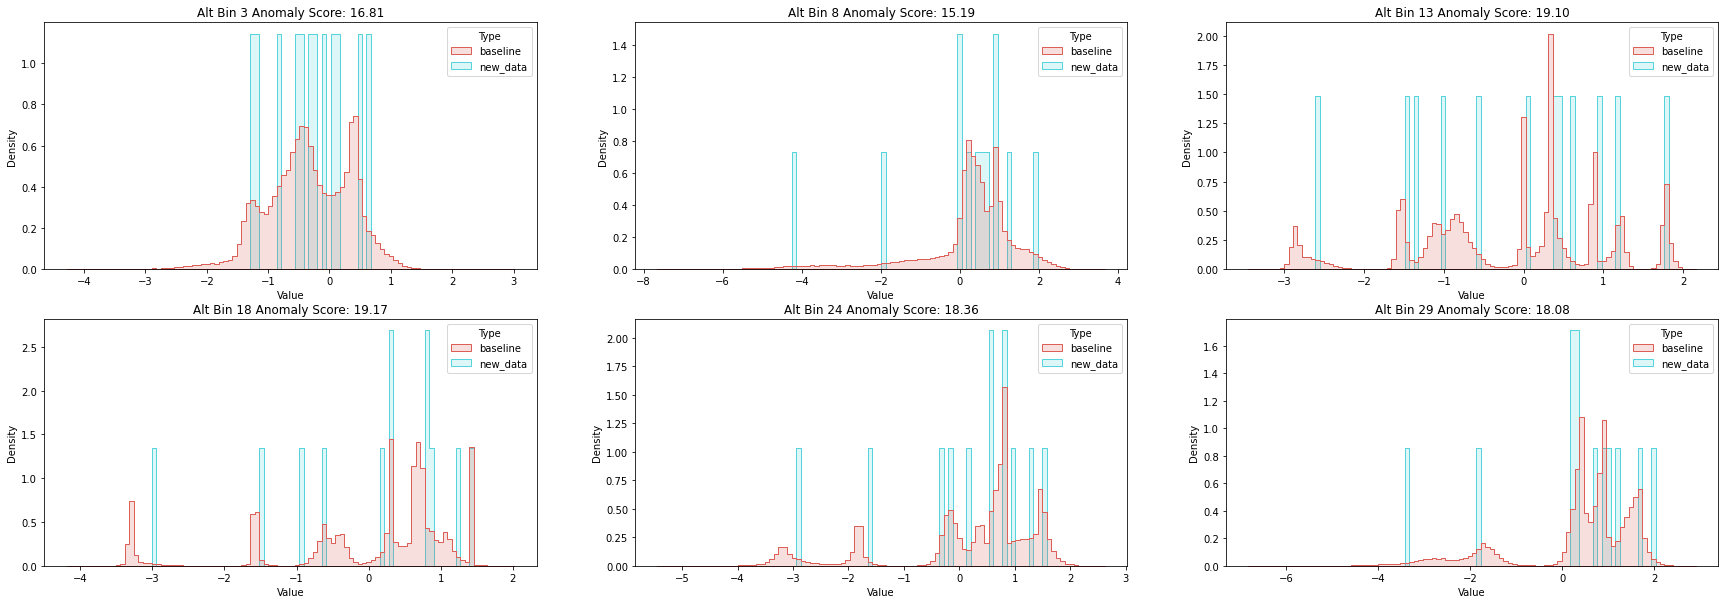

In [18]:
print('anomalies = {}'.format(anomalies))


alts = [a[-1] for a in const.alt_bins]
fig, ax = plt.subplots(2, 3, figsize=(30, 10))
for ii in range(2):
    for jj in range(3):
        index = 3 * ii + jj
        a = alts[index]
        mask = fakes[:, a, :].flatten() != float(0)
        x = np.hstack((fakes[:, a, :].flatten()[mask],
                       data[:, a, :].flatten()[mask]))
        hue = ['baseline'] * mask.sum() + ['new_data'] * mask.sum()
        d = pd.DataFrame({'Value': x, 'Type': hue})
        sns.histplot(data=d, x='Value', hue='Type',
                     element='step', bins=100, legend=True, stat='density',
                     palette='hls', alpha=0.2, common_norm=False, ax=ax[ii, jj],
                     hue_order=['baseline', 'new_data'], log_scale=False)
        ax[ii, jj].set_title(f'Alt Bin {const.alt_bins[index][-1]} Anomaly Score: {anomalies[alts[index]]:.2f}')
plt.show()